El cuaderno lo hice en Python3. Estos son los paquetes que se usan:

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import time
%matplotlib inline

## Extraer datos de la salida de WRF

> Salida que me pasó Daniel:

In [2]:
file = 'wrfout_d01_2012-05-30_00:00:00.nc'

In [3]:
nc = Dataset(file, 'r')

In [4]:
for i in nc.variables:
    print(i, nc.variables[i].shape)

Times (97, 19)
XLAT (97, 29, 29)
XLONG (97, 29, 29)
LU_INDEX (97, 29, 29)
ZNU (97, 59)
ZNW (97, 60)
ZS (97, 4)
DZS (97, 4)
VAR_SSO (97, 29, 29)
U (97, 59, 29, 30)
V (97, 59, 30, 29)
W (97, 60, 29, 29)
PH (97, 60, 29, 29)
PHB (97, 60, 29, 29)
T (97, 59, 29, 29)
HFX_FORCE (97,)
LH_FORCE (97,)
TSK_FORCE (97,)
HFX_FORCE_TEND (97,)
LH_FORCE_TEND (97,)
TSK_FORCE_TEND (97,)
MU (97, 29, 29)
MUB (97, 29, 29)
NEST_POS (97, 29, 29)
P (97, 59, 29, 29)
PB (97, 59, 29, 29)
FNM (97, 59)
FNP (97, 59)
RDNW (97, 59)
RDN (97, 59)
DNW (97, 59)
DN (97, 59)
CFN (97,)
CFN1 (97,)
THIS_IS_AN_IDEAL_RUN (97,)
P_HYD (97, 59, 29, 29)
Q2 (97, 29, 29)
T2 (97, 29, 29)
TH2 (97, 29, 29)
PSFC (97, 29, 29)
U10 (97, 29, 29)
V10 (97, 29, 29)
RDX (97,)
RDY (97,)
RESM (97,)
ZETATOP (97,)
CF1 (97,)
CF2 (97,)
CF3 (97,)
ITIMESTEP (97,)
XTIME (97,)
QVAPOR (97, 59, 29, 29)
QCLOUD (97, 59, 29, 29)
QRAIN (97, 59, 29, 29)
QICE (97, 59, 29, 29)
QSNOW (97, 59, 29, 29)
QGRAUP (97, 59, 29, 29)
QHAIL (97, 59, 29, 29)
QNCLOUD (97, 59, 29,

In [5]:
for dim in nc.dimensions:
    print(dim, nc.dimensions[dim])

Time <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 97

DateStrLen <class 'netCDF4._netCDF4.Dimension'>: name = 'DateStrLen', size = 19

west_east <class 'netCDF4._netCDF4.Dimension'>: name = 'west_east', size = 29

south_north <class 'netCDF4._netCDF4.Dimension'>: name = 'south_north', size = 29

bottom_top <class 'netCDF4._netCDF4.Dimension'>: name = 'bottom_top', size = 59

bottom_top_stag <class 'netCDF4._netCDF4.Dimension'>: name = 'bottom_top_stag', size = 60

soil_layers_stag <class 'netCDF4._netCDF4.Dimension'>: name = 'soil_layers_stag', size = 4

west_east_stag <class 'netCDF4._netCDF4.Dimension'>: name = 'west_east_stag', size = 30

south_north_stag <class 'netCDF4._netCDF4.Dimension'>: name = 'south_north_stag', size = 30



> Extraigo variables que se van a usar

In [9]:
g = 9.8
T = nc.variables['T']
u = nc.variables['U']
v = nc.variables['V']
T2 = nc.variables['T2']
PH = nc.variables['PH']
PHB = nc.variables['PHB']

In [7]:
xlat = nc.variables['XLAT']
xlong = nc.variables['XLONG']

xlat_u = nc.variables['XLAT_U']
xlong_u = nc.variables['XLONG_U']

xlat_v = nc.variables['XLAT_V']
xlong_v = nc.variables['XLONG_V']


---

## Interpolación de velocidades

Función que interpola las velocidades `u` y `v` al centro de la malla, donde están las cantidades escalares.

In [19]:
'''

    `XLON`, `XLAT`, `XLONG_U`, `XLAT_U`...  van con su dimensión temporal. 
    `U` no va con su dimensión temporal, sólo las dimensiones espaciales correspondientes a un tiempo.
    `uu` define si se trata de velocidad zonal o meridional, es decir si se está interpolando 'u', uu = True.
    `Kind`, tipo de interpolación. Por default es linear.
    
    ej: 
        interpolate_velocity(xlong, xlat, xlong_v, xlat_v, v, uu = False)

'''


def interpolate_velocity(XLONG, XLAT, XLONG_U, XLAT_U, U, uu = True, Kind = 'linear'):
    
    x_old = XLONG_U[0, 1, :]
    y_old = XLAT_U[0, :, 1]
    x_new = XLONG[0, 1, :]
    y_new = XLAT[0, :, 1]
    
    if uu == True:
        u_shape = (U.shape[0], U.shape[1], U.shape[2], U.shape[3]-1)
    
    else:
        u_shape = (U.shape[0], U.shape[1] ,U.shape[2] - 1, U.shape[3])
    
    
    U_out = np.zeros(u_shape, dtype='float32')
    #U_out = np.zeros(u_shape, dtype='float32')
    
    for t in range(0, U.shape[0]):
        for h in range(0, U.shape[1]):

            f = interpolate.interp2d(x_old, y_old, U[t, h, :, :], kind = Kind)
            U_out[t, h, :, :] = f(x_new, y_new)

    return U_out

Aquí hago la interpolación de la componente `u` de la velocidad al tiempo `t = 0`.

In [18]:
len(u.shape) == 4

True

In [20]:
u_interpol = interpolate_velocity(xlong, xlat, xlong_u, xlat_u, u)

In [21]:
u_interpol.shape

(97, 59, 29, 29)

In [22]:
start = time.time()

interpolate_velocity(xlong, xlat, xlong_u, xlat_u, u)

end = time.time()
print(end - start, 'seg')

2.007814884185791 seg


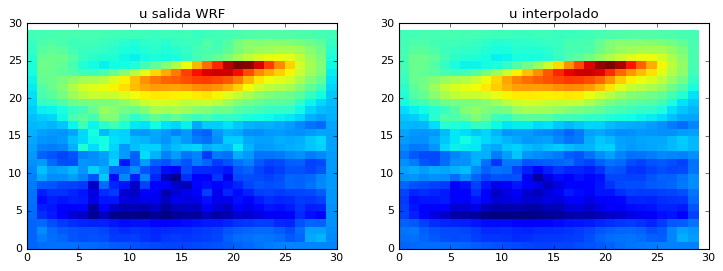

In [23]:
h = 57 # altura o número de capa
t = 20
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(221)
ax1.pcolor(u[t, h, :, :])
plt.title("u salida WRF")

ax2 = fig.add_subplot(222)
ax2.pcolor(u_interpol[t, h, :, :])
#ax2.title(title = 'u interpolado')
plt.title('u interpolado')

> Parece que se porta bien. 

### Ahora para v

Hago lo mismo pero para la componente v de la velocidad al tiempo `t = 0`.

In [24]:
v_interpol = interpolate_velocity(xlong, xlat, xlong_v, xlat_v, v, uu = False)

In [26]:
start = time.time()

interpolate_velocity(xlong, xlat, xlong_v, xlat_v, v, uu = False)

end = time.time()
print(end - start, 'seg')

2.0987789630889893 seg


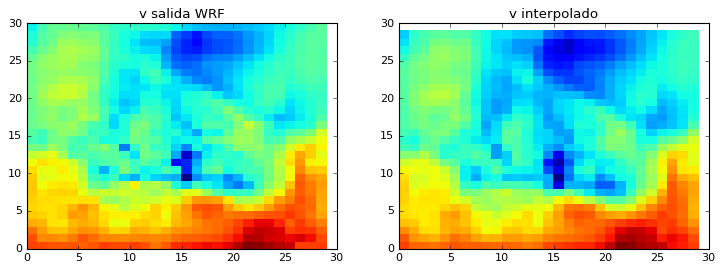

In [28]:
h = 30 # altura o número de capa
t = 13
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(221)
ax1.pcolor(v[t, h, :, :])
#Cs = plt.contour(relieve[1, :, :], colors= 'k')
#plt.clabel(Cs, fontsize = 8)
plt.title("v salida WRF")


ax2 = fig.add_subplot(222)
ax2.pcolor(v_interpol[t, h, :, :])
#Cs = plt.contour(relieve[1, :, :], colors= 'k')
#plt.clabel(Cs, fontsize = 8)
plt.title('v interpolado')

> Igual, parece que se porta bien.

---

## Compute height

Según el [el foro de usuarios de WRF](http://mailman.ucar.edu/pipermail/wrf-users/2011/002437.html) muchas variables de salida del WRF se encuentran en medio de la rejilla vertical, es por eso que cuando se calcula la altura usando las variables `PH` y `PHB`, se obtiene un valor extra en la componente vertical que no tienen  las otras variables, como las velocidades `U` y `V`. Esto se debe a que algunas variables se encuentran en medio de la malla vertical.

Lo que sugieren es promediar la altura de la capa de arriba con la altura de la capa de abajo, para obtener la altura en medio de la malla vertical, es decir:

`z = ((PH(n)+PHB(n)) + (PH(n+1) + PHB(n+1))) / 9.8`



In [29]:
PH.shape

(97, 60, 29, 29)

In [32]:
'''
    compute_height(PH, PHB)
    
    PH y PHB deben ser prporcionados como una matriz de tres dimensiones es decir hay especificar su variable temporal. 
    Por ejemplo: Para el tiempo t = 0, se debe introducir PH[0, :, :, :] y PHB[0, :, :, :].
'''

def compute_height(PH, PBH):
    
    g = 9.8
    z_shape = (PH.shape[0], PH.shape[1]-1, PH.shape[2], PH.shape[3])
    Z = np.zeros(z_shape, dtype='float32')
    
    for t in range(0, PH.shape[0]):
        for h in range(0, PH.shape[1]-1):

            Z[t, h, :, :] = ((PH[t, h, :, :] + PBH[t, h, :, :]) + (PH[t, h+1, :, :] + PBH[t, h+1, :, :]))/g
        
    return Z    

In [33]:
Z = compute_height(PH, PHB)

In [35]:
Z.shape

(97, 59, 29, 29)

In [56]:
start = time.time()

compute_height(PH, PHB)

end = time.time()
print(end - start, 'seg')

4.592158079147339 seg


In [57]:
z_range = range(0, len(Z[0, :, 20, 20]))

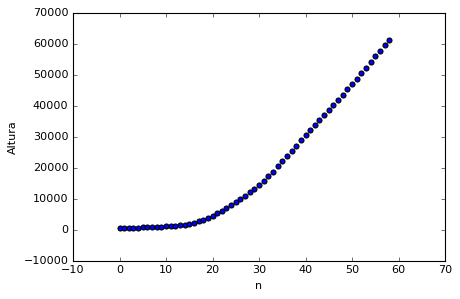

In [58]:
plt.scatter(z_range, Z[40, :, 20, 20])
plt.xlabel('n')
plt.ylabel('Altura')

In [59]:
Z[0, :, 20, 20][0] # Altura minima

593.16022

> Ahora para asegurame de que tengan sentido las alturas `Z`, las comparo la altura mínima con el relieve. Para tomo cuatro puntos al azar hago la comparación. También los grafico en un mapa con el relieve. 

In [60]:
relieve = nc.variables['HGT']

##### Punto Rojo

In [61]:
print('Lat = ', xlat[0,20,20])
print('Long = ', xlong[0,20,20])
print('Altura mínima = ', Z[0, 0, 20, 20])
print('Relieve = ', relieve[0,20, 20])

Lat =  20.6172
Long =  -97.9258
Altura mínima =  593.16
Relieve =  285.038


##### Punto verde

In [62]:
print('Lat = ', xlat[0,3,23])
print('Long = ', xlong[0,3,23])
print('Altura mínima = ', Z[0, 0, 3, 23])
print('Relieve = ', relieve[0, 3, 23])

Lat =  18.3195
Long =  -97.4957
Altura mínima =  3675.34
Relieve =  1824.99


##### Punto azul

In [63]:
print('Lat = ', xlat[0,20,12])
print('Long = ', xlong[0,20,12])
print('Altura mínima = ', Z[0, 0, 20, 12])
print('Relieve = ', relieve[0,20, 12])

Lat =  20.6172
Long =  -99.0727
Altura mínima =  3965.16
Relieve =  1969.77


##### Punto cyan

In [64]:
print('Lat = ', xlat[0,28,28])
print('Long = ', xlong[0,28,28])
print('Altura mínima = ', Z[0, 0, 28, 28])
print('Relieve = ', relieve[0, 28, 28])

Lat =  21.6868
Long =  -96.7789
Altura mínima =  22.4576
Relieve =  0.0


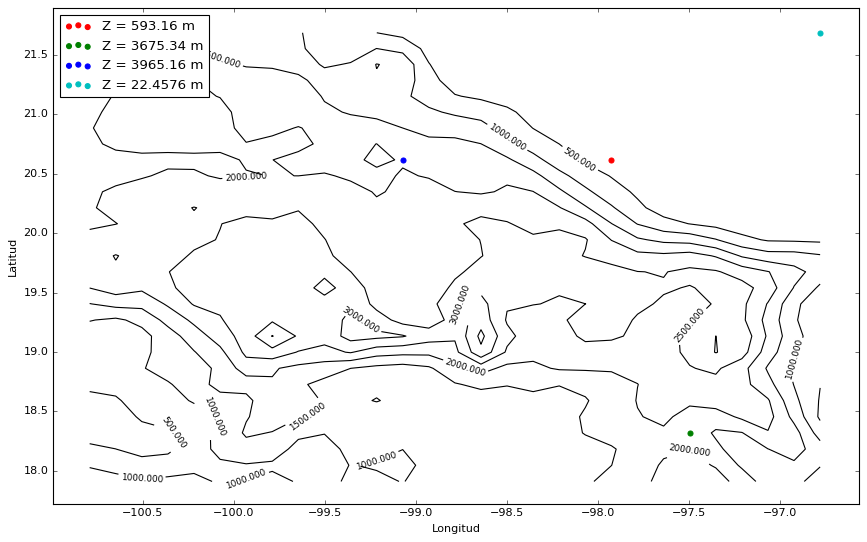

In [65]:
fig = plt.figure(figsize=(13,8))
Cs = plt.contour(xlong[0,:,:], xlat[0,:, :], relieve[0, :, :], colors= 'k')
plt.clabel(Cs, fontsize = 8)
plt.scatter(xlong[0,20,20], xlat[0,20,20], color='r', label=('Z = 593.16 m'))
plt.scatter(xlong[0,3,23], xlat[0,3,23], color='g', label=('Z = 3675.34 m'))
plt.scatter(xlong[0,20,12], xlat[0,20, 12], color='b', label=('Z = 3965.16 m'))
plt.scatter(xlong[0,28,28], xlat[0,28, 28], color='c', label=('Z = 22.4576 m'))
plt.legend(loc = 2)
plt.xlabel('Longitud')
plt.ylabel('Latitud')

> **Obs:** 
- Parece que hay diferencias grandes entre el relieve y la menor altura Z, sobretodo en el punto verde y el punto azul. 
- Una de las cosas que no me gustan es que las alturas calculadas llegan hasta 60 mil metros de altura... ¿Está bien que sea así?

Altura máxima:  61499.3


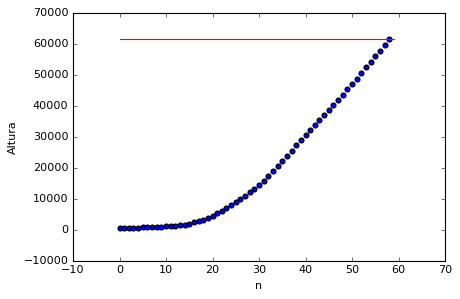

In [66]:
print('Altura máxima: ', Z[0, :, 20, 20].max())
plt.scatter(z_range, Z[0, :, 20, 20])
plt.xlabel('n')
plt.ylabel('Altura')
plt.plot(range(0,60), np.zeros(len(range(0,60))) + Z[0, :, 20, 20].max(), color = 'r')

---

## Número de Richardson

Se usa el algoritmo para calcular Richardson que viene en el artículo de [S. Joffre](https://link.springer.com/article/10.1023%2FA%3A1018956525605?LI=true):

$$Ri(z_{i+1}) = \frac{g}{T_s} \frac{(\theta_{i+2} - \theta_i)(z_{i+2} - z_i)}{(V_{i+2} - V_i)^2}.$$

Si se cambian los índices se tiene:

$$Ri(z_{i}) = \frac{g}{T_s} \frac{(\theta_{i+1} - \theta_{i-1})(z_{i+1} - z_{i-1})}{(V_{i+1} - V_{i-1})^2}.$$

> La función `compute_Richardson` sólo calcula los números de Richardson de una sola columna de datos, por tanto es necesario especificar el tiempo y y las coordenadas de la colmuna que se va a calcular.


In [68]:
Z.shape[1:4]

(59, 29, 29)

In [70]:
"""
    compute_Richardson(T_s, θ, Z, u, v):
    
        `T_s` es la altura cerca de la superficie.
        `θ` es la temperatura potencial.
        `Z` altura de capa
        `u` y `v` componentes zonal u meridional de la velocidad.
        
        
"""

def compute_Richardson(T_s, θ, Z, u, v):
    g = 9.8
    Ri = np.zeros(Z.shape, dtype='float32')
    
    for i in range(1,len(θ)-2):
        
        Vu = np.sqrt(u[i+1]**2 + v[i+1]**2)
        Vd = np.sqrt(u[i-1]**2 + v[i-1]**2)
        
        Ri[i] = g / T_s * ((θ[i+1] - θ[i-1])*(Z[i+1] - Z[i-1]))/(Vu - Vd)**2
    
    return Ri

- Para la variable `T_s` temperatura de superficie, uso la temperatura a 2 metros de superficie (`T2` de la salida del WRF).
- La temperatura potencial es la variable `T` de la salida del WRF.
- Z son las alturas al tiempo cero que se calcularon con `compute_heights`.
- para `u` y `v` uso `u_interpol` y `v_interpol`, que son las velocidades interpoladas al tiempo cero.


In [71]:
nx = 20 #coordenada x
ny = nx #coord. y
t = 0 #tiempo (tal vez iteración)

print('Latitud ', xlat[t, nx, ny])
print('Longitud', xlong[t, nx, ny])
print('tiempo', 0)

Ri = compute_Richardson(T2[t, nx, ny], T[t, :, nx, ny], Z[t, :, nx, ny], u_interpol[t, :, nx, ny], v_interpol[t, :, nx, ny])

Latitud  20.6172
Longitud -97.9258
tiempo 0


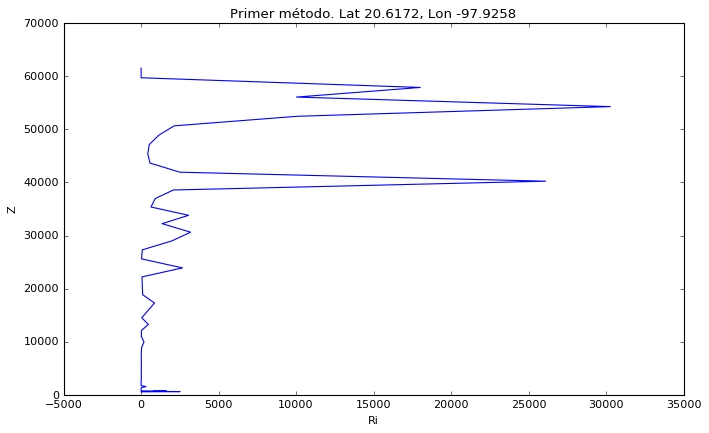

In [73]:
plt.figure(figsize=(10,6))
plt.plot(Ri, Z[t, :, nx, ny])
plt.xlabel("Ri")
plt.ylabel('Z')
plt.title('Primer método. Lat ' + str(xlat[t, nx, ny]) + ', Lon ' + str(xlong[t, nx, ny]))

> Si sólo grafico para las alturas 0 hasta 4000, se tiene:

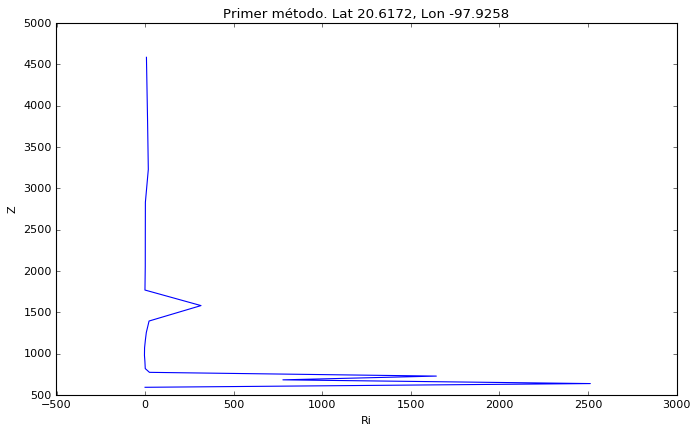

In [74]:
zoom_range = range(0, 21)
plt.figure(figsize=(10,6))
plt.plot(Ri[zoom_range], Z[t, zoom_range, nx, ny])
plt.xlabel("Ri")
plt.ylabel('Z')
plt.title('Primer método. Lat ' + str(xlat[t, nx, ny]) + ', Lon ' + str(xlong[t, nx, ny]))

**Observaciones:** Claramente algo está mal. 

## Probando el segundo método

El segundo método viene en el artículo de [Xueliang Feng](http://www.mdpi.com/2073-4433/6/9/1346/htm), donde se calcula el número de Richardson de la siguiente forma:

$$Ri(z) = \frac{g \ (z -z_0)(\theta(z) - \theta_0)}{\theta(z)(u(z)^2) + v(z)^2)}$$

En el artículo no especifican que es $\theta_0$ y $z_0$. Yo asumí que se trata de $\theta_0$ es la temperatura potencial en la capa más pequeña y que $z_0$ es la altura de la capa inferior. _Probablemente esto esté mal_.

> Igual que en la función anterior, `compute_Richardson_2` sólo calcula el número de Richardson para una sola columna.

In [75]:
def compute_Richardson_2(θ, Z, u, v):
    g = 9.8
    Ri = np.zeros(Z.shape, dtype='float32')
    
    for i in range(0,len(θ)-1):
        
        Ri[i] = (g*(θ[i] - θ[0])*(Z[i] - Z[0]))/(θ[i] * (u[i]**2 + v[i]**2))
    
    return Ri

In [78]:
nx = 20 # coord. x
ny = nx #coord. y
t = 0 #tiempo

print('Latitud ', xlat[t, nx, ny])
print('Longitud', xlong[t, nx, ny])
print('tiempo', 0)
Ri2 = compute_Richardson_2(T[t, :, nx, ny], Z[t, :, nx, ny], u_interpol[t, :, nx, ny], v_interpol[t, :, nx, ny])

Latitud  20.6172
Longitud -97.9258
tiempo 0


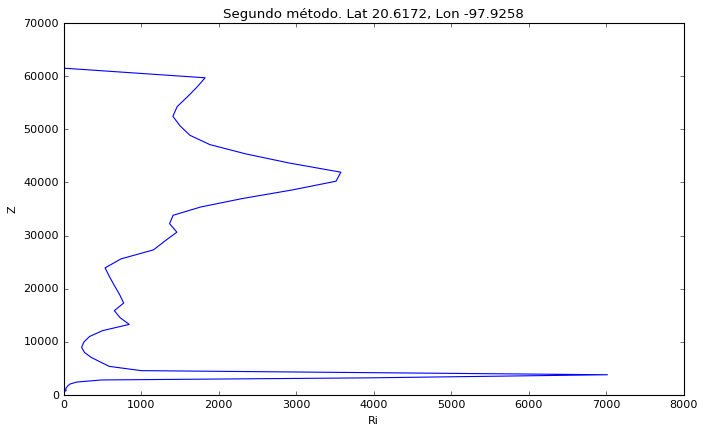

In [79]:
plt.figure(figsize=(10,6))
plt.plot(Ri2, Z[t, :, nx, ny])
plt.xlabel("Ri")
plt.ylabel('Z')
plt.title('Segundo método. Lat ' + str(xlat[t, nx, ny]) + ', Lon ' + str(xlong[t, nx, ny]))

> Haciendo zoom para las alturas entre 0 y 4000 m.

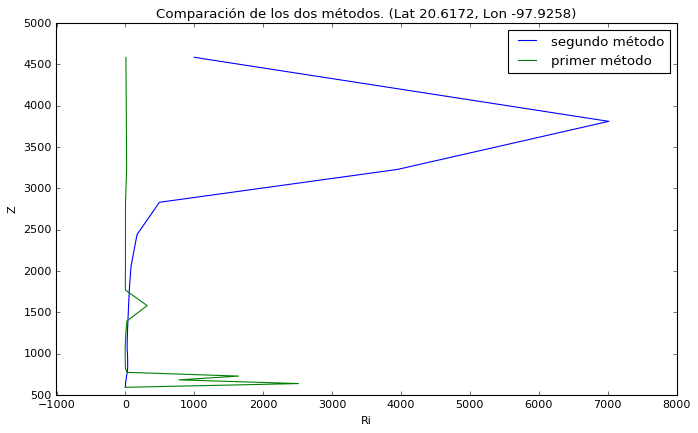

In [80]:
zoom_range = range(0, 21)
plt.figure(figsize=(10,6))
plt.plot(Ri2[zoom_range], Z[t, zoom_range, nx, ny], label='segundo método')
plt.plot(Ri[zoom_range], Z[t, zoom_range, nx, ny], label = 'primer método')
plt.xlabel("Ri")
plt.ylabel('Z')
plt.legend()
plt.title('Comparación de los dos métodos. (Lat ' + str(xlat[t, nx, ny]) + ', Lon ' + str(xlong[t, nx, ny])+ ')')

#### Probando otro punto

In [81]:
nx = 3 # coord. x
ny = 23 #coord. y
t = 0 #tiempo

print('Latitud ', xlat[t, nx, ny])
print('Longitud', xlong[t, nx, ny])
print('tiempo', 0)

Ri = compute_Richardson(T2[t, nx, ny], T[t, :, nx, ny], Z[t, :, nx, ny], u_interpol[t, :, nx, ny], v_interpol[t, :, nx, ny])
Ri2 = compute_Richardson_2(T[t, :, nx, ny], Z[t, :, nx, ny], u_interpol[t, :, nx, ny], v_interpol[t, :, nx, ny])

Latitud  18.3195
Longitud -97.4957
tiempo 0


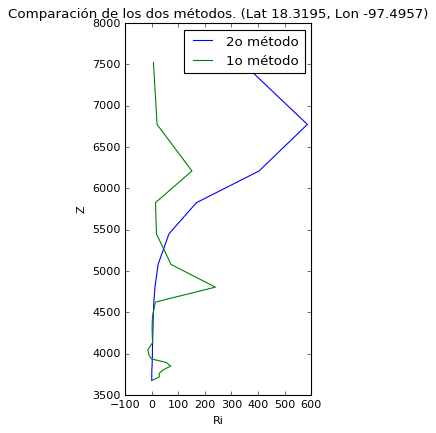

In [84]:
zoom_range = range(0, 21)
plt.figure(figsize=(3,6))
plt.plot(Ri2[zoom_range], Z[t, zoom_range, nx, ny], label='2o método')
plt.plot(Ri[zoom_range], Z[t, zoom_range, nx, ny], label = '1o método')
plt.xlabel("Ri")
plt.ylabel('Z')
plt.legend()
plt.title('Comparación de los dos métodos. (Lat ' + str(xlat[t, nx, ny]) + ', Lon ' + str(xlong[t, nx, ny])+ ')')

## Evolucion en el tiempo de un perfil 

In [98]:
len(t_range)

5

In [103]:
(5, Z[0,:, 1,1].shape[0])

(5, 59)

In [108]:
A = np.array([], dtype = 'float32')

In [110]:
nx = 3 # coord. x
ny = 23 #coord. y
t_range = range(0, 50, 10) #tiempo

print('Latitud ', xlat[t, nx, ny])
print('Longitud', xlong[t, nx, ny])
#print('tiempo', 0)
Ri = np.zeros((len(t_range), Z[0,:, 1,1].shape[0]), dtype='float32')
Ri2 = np.zeros((len(t_range), Z[0,:, 1,1].shape[0]), dtype='float32')

for t in range(0, len(t_range)):
    ti = t_range[t]
    Ri[t, :] = compute_Richardson(T2[ti, nx, ny], T[ti, :, nx, ny], Z[ti, :, nx, ny], u_interpol[ti, :, nx, ny], v_interpol[ti, :, nx, ny])
    Ri2[t, :] = compute_Richardson_2(T[ti, :, nx, ny], Z[ti, :, nx, ny], u_interpol[ti, :, nx, ny], v_interpol[ti, :, nx, ny])

Latitud  18.3195
Longitud -97.4957
tiempo 0


In [112]:
Ri.shape

(5, 59)

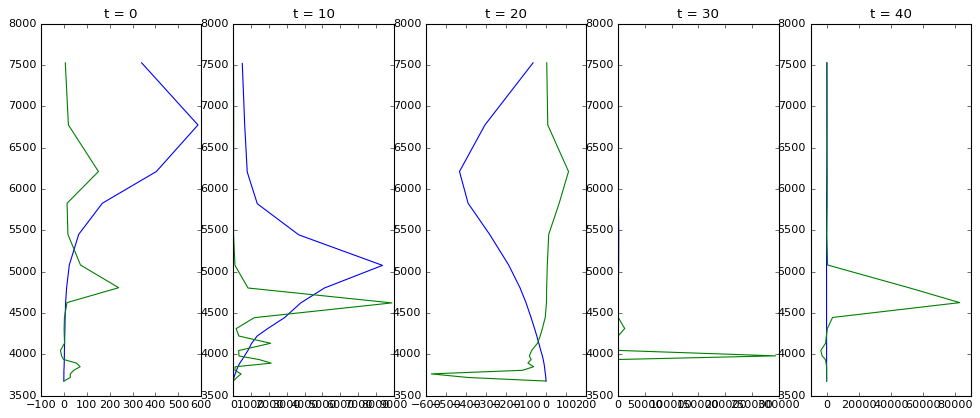

In [129]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(151)
ax1.plot(Ri2[0, zoom_range], Z[0, zoom_range, nx, ny])
ax1.plot(Ri[0, zoom_range], Z[0, zoom_range, nx, ny])
plt.title("t = " + str(t_range[0]))

ax2 = fig.add_subplot(152)
ax2.plot(Ri2[1, zoom_range], Z[1, zoom_range, nx, ny])
ax2.plot(Ri[1, zoom_range], Z[1, zoom_range, nx, ny])
plt.title("t = " + str(t_range[1]))

ax3 = fig.add_subplot(153)
ax3.plot(Ri2[2, zoom_range], Z[0, zoom_range, nx, ny])
ax3.plot(Ri[2, zoom_range], Z[0, zoom_range, nx, ny])
plt.title("t = " + str(t_range[2]))

ax4 = fig.add_subplot(154)
ax4.plot(Ri2[3, zoom_range], Z[0, zoom_range, nx, ny])
ax4.plot(Ri[3, zoom_range], Z[0, zoom_range, nx, ny])
plt.title("t = " + str(t_range[3]))

ax5 = fig.add_subplot(155)
ax5.plot(Ri2[4, zoom_range], Z[0, zoom_range, nx, ny])
ax5.plot(Ri[4, zoom_range], Z[0, zoom_range, nx, ny])
plt.title("t = " + str(t_range[4]))
